# Please for each question, provide:
- a callable function that returns the requested result
- a second function that tests the behaviour of the first function (that answers the question), by running the first function on a simple testcase, and using an assertion or raising an error if the test fails. 

# Question regarding center of mass in a volume


Write a function to find the center of mass of the provided 3d volume.

The code bellow loads volume, and displays its projections,
Use a scipy's center of mass function (or a function of your own!) to find the center of mass of the provided volume.

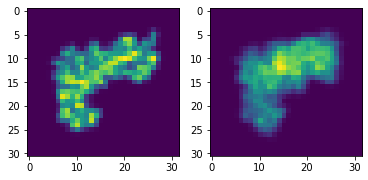

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_volume_data(
    filename: str = "1CS4.npz",
    arrayname: str = "map_1CS4"):
    # load the 3d volume as a numpy array
    volume = np.load(filename)[arrayname]
    return volume

def plot_volume_projection(
    volume: np.array):
    fig, axes = plt.subplots(1,2)
    # display the center slice of the volume
    axes[0].imshow(volume[15])
    # display the x-axis projection of the volume
    axes[1].imshow(volume.sum(axis=0))
    plt.show()

volume = load_volume_data()
plot_volume_projection(volume)

#testcase hint (what does centre of mass return if provided with an array containing only zeros, and a one at a specific index?)

In [2]:
# import center_of_mass function from scipy
from scipy.ndimage.measurements import center_of_mass

# calculate center of mass for nD volume
def centerofmass(volume):
    cm = center_of_mass(volume)
    return cm

In [3]:
# test the function
def test_centerofmass():
    arr = np.array(([0,0,0,0], [0,1,1,0], [0,1,1,0], [0,1,1,0]))
    assert center_of_mass(arr) == (2.0, 1.5), "Wrong output!!!"
    
test_centerofmass()

# Question regarding finding motifs, distribution

You are provided with a list of motifs, and a clustal file containing aligned protein sequences.

Write a function that, using a pandas dataframe (or a formatted data structure, e.g. a dict of dicts), store the number of times each motif appear in a given sequence, and return that dataframe.

**Only write a test for this function, not the next one**

Write a separate function that computes the average number of occurrences of the motif in the provided file.

In [4]:
motifs = ["LL", "EE", "W"]
aligned_filename = "hAPP.clustal"

In [5]:
import pandas as pd
from collections import defaultdict

# generate list of kmers from a given sequence
def kmer(seq, k):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

# count motif in each aligned protein sequence
def count_motifs(aligned_filename, motifs):
    with open(aligned_filename, "r") as f:
        # declare dict of dicts object
        counts = defaultdict(dict)
        # iterate over each line
        for line in f:
            # don't consider the first line and the empty lines
            if line.strip() and ("CLUSTAL" not in line.strip().upper()):
                # extract seq from line
                seq = line.strip().split()[1]
                # iterate over each motif
                for motif in motifs:
                    k = len(motif)
                    # generate kmers for seq
                    kmers = kmer(seq, k)
                    # count motifs
                    try:
                        counts[seq][motif] += kmers.count(motif)
                    except KeyError:
                        counts[seq][motif] = 0
    # return motif counts as pandas dataframe
    return pd.DataFrame(counts).T

# call the function and view results
df = count_motifs(aligned_filename, motifs)
df.head()

,LL,EE,W
--MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSG,36,0,18
--MLPGLALLLLAAWTARAL----------------------------------------,0,0,0
MDQLEDLLVL-------FINYVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSG,0,0,0
TKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCL,0,0,10
----------------EVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCL,0,0,0


In [6]:
#Hint for the testcase: look at a slice of the first few characters in the sequence
def test_count_motifs(aligned_filename, motifs):
    df = count_motifs(aligned_filename, motifs)
    assert df.index[0] == "--MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSG", "Wrong answer!!!"
    
test_count_motifs(aligned_filename, motifs)

# Question regarding database and pandas

You are provided with a SQLite database, `emdb.db`, containing a table `entries` with the emdb id, title, and date of deposition of various EMDB entries.

Write a function that takes the database and a search term as an input and:
- select the data from the database
- discard the entries whose title do not match the search term
- create and return a dataframe (or a formatted data structure, e.g. a list of lists) with the content from the database, sorted by descending order of deposition (newest first, oldest last)

In [7]:
# The code below is a reference for the construction of the emdb databse

import sqlite3
import requests

con = sqlite3.connect("emdb.db")
cur = con.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS entries(id, title, date)")
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchone()

emdb_api = "https://www.ebi.ac.uk/emdb/api"
search_term = "virus"
search_request = f"{emdb_api}/search/{search_term}"

r = requests.get(search_request)
entries_json = r.json()

data = [(e['emdb_id'], e['admin']['title'], e['admin']['key_dates']['deposition']) for e in entries_json]
cur.executemany("INSERT INTO entries VALUES(?, ?, ?)", data)
con.commit()

In [8]:
database_name = "emdb.db"
# example search term, should work for any search term!
search_term = "Life"

def get_info(database_name, search_term):
    con = sqlite3.connect(database_name)
    cur = con.cursor()
    cur.execute("CREATE TABLE IF NOT EXISTS entries(id, title, date)")
    res = cur.execute("SELECT name FROM sqlite_master")
    res.fetchone()

    emdb_api = "https://www.ebi.ac.uk/emdb/api"
    search_request = f"{emdb_api}/search/{search_term}"

    r = requests.get(search_request)
    entries_json = r.json()

    data = [(e['emdb_id'], e['admin']['title'], e['admin']['key_dates']['deposition']) for e in entries_json]
    cur.executemany("INSERT INTO entries VALUES(?, ?, ?)", data)
    con.commit()
    # sort the data in descending order according to deposition
    data = sorted(data, key=lambda x:x[2], reverse=True)
    return data

In [9]:
#testcasehint: How many entries would you expect to get for the search term "ZZZZXYZ"? for "" ?
def test_get_info():
    assert len(get_info("emdb.db", "ZZZZXYZ"))==0, "Wtong output!!!"
    
test_get_info()